# Using CNN to classify tomato leaf diseases

10 classes:
* Tomato mosaic virus
* Target spot
* Bacterial spot
* Yellow leaf curl virus
* Late blight
* Leaf mold
* Early blight
* Spider mites two-spotted spider mite
* Septoria leaf spot
* Healthy

In [ ]:
! pip install torchinfo
! pip install optuna
! pip install kaggle

In [ ]:
# kaggle dataset 
import os
os.environ['KAGGLE_USERNAME'] = "" 
os.environ['KAGGLE_KEY'] = ""
!kaggle datasets download -d noulam/tomato

100% 742M/743M [00:37<00:00, 21.0MB/s]
100% 743M/743M [00:37<00:00, 20.9MB/s]


In [ ]:
! unzip /content/tomato.zip

# Dataset

In [ ]:
# libraries
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchinfo import summary
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
import torchvision.transforms as tr

import optuna
import optuna.visualization as visualization

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# available device
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
# key components
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_path = '/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
test_path = '/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/test'  # cambia nome cartella valid
n_classes = 10
batch_size = 32
num_epochs = 20
# training-validation components
train_accuracy = []
train_loss = []
validation_accuracy = []
validation_loss = []
best = 100  # used to save best model and best model performances 

In [ ]:
# image dataset for visualizing images without transformations
data = ImageFolder(train_path, transform=tr.Compose([tr.Resize((232, 232)), tr.ToTensor()]))

In [ ]:
# classes
data.class_to_idx

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [ ]:
# function for displaying random images from selected dataset 
classes = {v: k.replace('Tomato___', '') for k, v in data.class_to_idx.items()}  # adjusting classes for better visualization
def show(dataset, classes=classes):
    plt.figure(figsize=(16, 8))
    for i in range(10):
        index = np.random.randint(0, len(dataset))
        plt.subplot(2, 5, i+1)
        plt.imshow(dataset[index][0].permute((1, 2, 0)))
        plt.title(classes[dataset[index][1]])
        plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.01)
    plt.tight_layout()

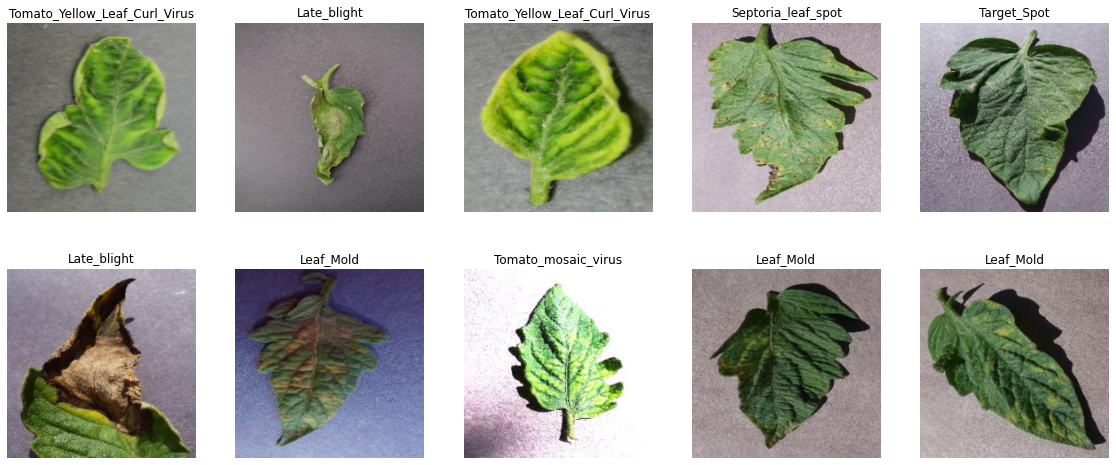

In [ ]:
show(data)

In [ ]:
mean = [0.485, 0.456, 0.406]  # mean and standard deviation derived from pytorch (used in the original ResNet50 training on the Imagenet Dataset)
std = [0.229, 0.224, 0.225]

train_transform = tr.Compose([
    tr.Resize((232, 232)),
    tr.CenterCrop(224),
    tr.RandomRotation(degrees=(0, 180)),  # prevent overfitting
    tr.ToTensor(),
    tr.Normalize(mean=mean, std=std)
])
test_transform = tr.Compose([
    tr.Resize((232, 232)),
    tr.ToTensor(),
    tr.Normalize(mean=mean, std=std)
])

In [ ]:
# train and test datasets (transformations applied)
train_dataset = ImageFolder(train_path, transform=train_transform)
test_ds = ImageFolder(test_path, transform=test_transform)

In [ ]:
# function to check dataset balance
def check_balance(ds):
    l = []
    for x, y in ds:
        l.append(y)
    ser = pd.Series(l).value_counts()
    print(ser / ser.sum())

In [ ]:
check_balance(train_dataset)

7    0.106896
9    0.104988
1    0.104661
3    0.102589
2    0.100899
6    0.099591
8    0.097574
4    0.095121
5    0.094903
0    0.092777
dtype: float64


In [ ]:
check_balance(test_ds)

7    0.106870
9    0.104907
1    0.104689
3    0.102508
2    0.100981
6    0.099673
8    0.097710
4    0.095093
5    0.094875
0    0.092694
dtype: float64


The two datasets are balanced

In [ ]:
print('Train Dataset', train_dataset)
print('Test Dataset', test_ds)

Train Dataset Dataset ImageFolder
    Number of datapoints: 18345
    Root location: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train
    StandardTransform
Transform: Compose(
               Resize(size=(232, 232), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test Dataset Dataset ImageFolder
    Number of datapoints: 4585
    Root location: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/test
    StandardTransform
Transform: Compose(
               Resize(size=(232, 232), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


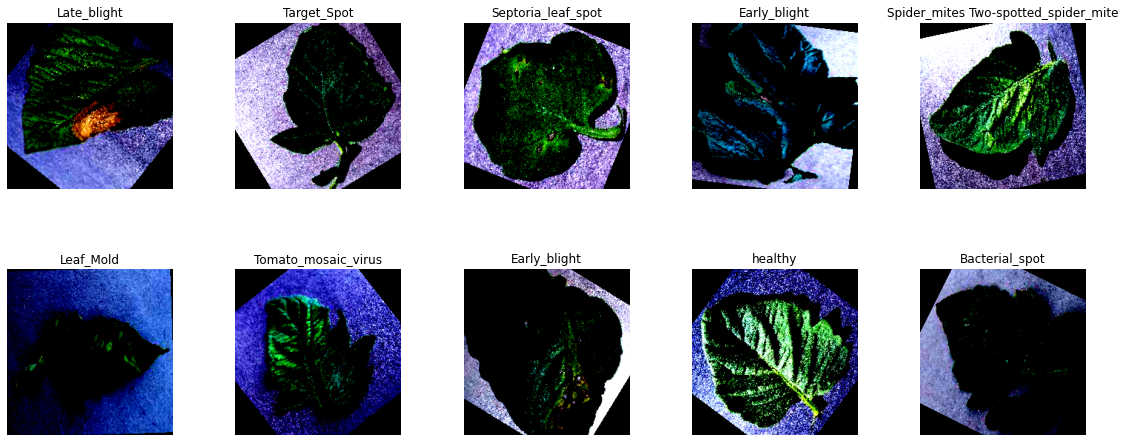

In [ ]:
# transformed images of train dataset
show(train_dataset)

In [ ]:
# splitting the original train dataset in train-validation
train_ds, valid_ds = random_split(train_dataset, [0.8, 0.2])

In [ ]:
# creation of train-valid-test dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

# Model Optimization

In [ ]:
# base model
model = resnet50(weights='IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# base model architecture and parameters
summary(model=model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

The base model was applied to the tomato leaf disease problem by training only the last three layers. The classifier (last layer) was reconstructed to initialize new parameters, while the bottlenecks of the fourth layer were trained with lower learning rates to retain valuable information.

In [ ]:
# layers choosen to be modified
model.layer4[1:]

Sequential(
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (2): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, ker

## Implementing Optuna for optimization of hyperparameters
### Key points:
* objective: minimizing the average loss of the last 3 epochs
* classifier: last layer is a fully connected layer
* loss function: choice between CrossEntropyLoss and MultiMarginLoss
* optimizer: Adam
* learning rate: varying based on layer
* scheduler: usage of a simple step scheduler 
* epochs: 20

In [ ]:
# in_features
in_feat = model.fc.in_features

In [ ]:
def objective(trial):
    global best, train_accuracy, train_loss, validation_accuracy, validation_loss  # object to be updated in case of a best model

    model_o = resnet50(weights='IMAGENET1K_V2')

    for param in model_o.parameters():  # freeze parameters
        param.requires_grad = False
    
    model_o.fc = nn.Linear(in_features=in_feat, out_features=n_classes)  # creation of last layer
    
    for param in model_o.layer4[1:].parameters():  # unfreeze selected layers
        param.requires_grad = True
    
    model_o = model_o.to(device)
    
    # loss function
    loss_function = trial.suggest_categorical('loss_function', ['CrossEntropyLoss', 'MultiMarginLoss'])
    loss_fn = getattr(nn, loss_function)()

    # optimizer
    lr_1 = trial.suggest_float('lr_layer4_1', 1e-8, 1e-4, log=True)  # choosing varying learning rates for distinct layers
    lr_2 = trial.suggest_float('lr_layer4_2', 1e-7, 1e-4, log=True)
    lr_3 = trial.suggest_float('lr_classifier', 1e-4, 1e-1, log=True)
    
    optimizer = torch.optim.Adam([
        {'params': model_o.layer4[1].parameters(), 'lr': lr_1},
        {'params': model_o.layer4[2].parameters(), 'lr': lr_2},
        {'params': model_o.fc.parameters()}
        ], lr=lr_3)
    
    gamma = trial.suggest_categorical('scheduler_gamma', [0.8, 0.7, 0.6])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=8, gamma=gamma)  # scheduler
    
    acc_h_t = [0] * num_epochs
    loss_h_t = [0] * num_epochs
    acc_h_v = [0] * num_epochs
    loss_h_v = [0] * num_epochs
    count = 0
    
    for epoch in range(num_epochs):
        
        model_o.train()
        for x_t, y_t in train_dl:
            x_t = x_t.to(device)
            y_t = y_t.to(device)

            pred_t = model_o(x_t)
            loss_t = loss_fn(pred_t, y_t)
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
            
            corr_t = (torch.argmax(pred_t, dim=1) == y_t).float()
            acc_h_t[epoch] += corr_t.sum().cpu()
            loss_h_t[epoch] += loss_t.item()
        acc_h_t[epoch] /= len(train_ds)
        loss_h_t[epoch] /= len(train_dl)
        
        model_o.eval()
        with torch.no_grad():
            for x_v, y_v in valid_dl:
                x_v = x_v.to(device)
                y_v = y_v.to(device)
                
                pred_v = model_o(x_v)
                loss_v = loss_fn(pred_v, y_v)
                
                corr_v = (torch.argmax(pred_v, dim=1) == y_v).float()
                acc_h_v[epoch] += corr_v.sum().cpu()
                loss_h_v[epoch] += loss_v.item()
        acc_h_v[epoch] /= len(valid_ds)
        loss_h_v[epoch] /= len(valid_dl)
        
        scheduler.step()
        
        # optuna pruning process
        trial.report(acc_h_v[epoch], epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    # objective
    score = np.mean(loss_h_v[-3:])

    # model and performances saving
    if score < best:
        best = score
        train_accuracy = acc_h_t
        train_loss = loss_h_t
        validation_accuracy = acc_h_v
        validation_loss = loss_h_v
        torch.save(model_o, 'intermediate_model.pt')
    
    return score

In [ ]:
# optuna optimization process
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=4, show_progress_bar=True)

print(f'Best score: {study.best_value}')
for k, v in study.best_params.items():
    print(f'{k}: {v}')

[I 2023-01-24 13:20:31,847] A new study created in memory with name: no-name-08cc5041-c903-4c74-897a-b098ba71800a


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2023-01-24 14:00:12,351] Trial 0 finished with value: 0.004841698600226875 and parameters: {'loss_function': 'MultiMarginLoss', 'lr_layer4_1': 3.0349301296414345e-05, 'lr_layer4_2': 4.0028055479862796e-07, 'lr_classifier': 0.0031333553167871312, 'scheduler_gamma': 0.6}. Best is trial 0 with value: 0.004841698600226875.
[I 2023-01-24 14:39:38,346] Trial 1 finished with value: 0.0436274323550026 and parameters: {'loss_function': 'CrossEntropyLoss', 'lr_layer4_1': 1.535050900406023e-07, 'lr_layer4_2': 8.82049606781412e-05, 'lr_classifier': 0.0010674347123060441, 'scheduler_gamma': 0.7}. Best is trial 0 with value: 0.004841698600226875.
[I 2023-01-24 15:18:57,605] Trial 2 finished with value: 0.04565228561573811 and parameters: {'loss_function': 'CrossEntropyLoss', 'lr_layer4_1': 2.1479511824268544e-05, 'lr_layer4_2': 1.9529139446245505e-07, 'lr_classifier': 0.00011758946879936194, 'scheduler_gamma': 0.7}. Best is trial 0 with value: 0.004841698600226875.
[I 2023-01-24 15:58:03,557] Tri

In [ ]:
# trials results
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_loss_function,params_lr_classifier,params_lr_layer4_1,params_lr_layer4_2,params_scheduler_gamma,state
0,0,0.004842,2023-01-24 13:20:31.874261,2023-01-24 14:00:12.350741,0 days 00:39:40.476480,MultiMarginLoss,0.003133,3.034930e-05,4.002806e-07,0.6,COMPLETE
1,1,0.043627,2023-01-24 14:00:12.357299,2023-01-24 14:39:38.346409,0 days 00:39:25.989110,CrossEntropyLoss,0.001067,1.535051e-07,8.820496e-05,0.7,COMPLETE
2,2,0.045652,2023-01-24 14:39:38.354197,2023-01-24 15:18:57.604792,0 days 00:39:19.250595,CrossEntropyLoss,0.000118,2.147951e-05,1.952914e-07,0.7,COMPLETE
3,3,0.040491,2023-01-24 15:18:57.610156,2023-01-24 15:58:03.557249,0 days 00:39:05.947093,MultiMarginLoss,0.079099,1.231963e-05,5.911989e-05,0.8,COMPLETE


# Optuna study visualizations
(these figure could not compare in the github notebook)

In [ ]:
# trial's scores
visualization.plot_intermediate_values(study)

In [ ]:
# hyperparameters importances
visualization.plot_param_importances(study)

In [ ]:
# relationship between hyperparameters and objective
visualization.plot_slice(study)

# Functions for model testing

In [ ]:
# function for accuracy-loss history visualization
def plot_acc_loss(acc_t, acc_v, loss_t, loss_v):
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))
    ax[0].plot(acc_t, label='Train accuracy', marker='o', color='navy')
    ax[0].plot(acc_v, label='Validation accuracy', marker='o', color='r')
    ax[1].plot(loss_t, label='Train loss', marker='o', color='navy')
    ax[1].plot(loss_v, label='Validation loss', marker='o', color='r')
    ax[0].set(title='Accuracy', xlabel='Epoch')
    ax[1].set(title='Loss', xlabel='Epoch')
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()

In [ ]:
# function to store testing results
def evaluete_model(mod):
    y_true = []
    y_pred = []
    y_prob = []

    mod.eval()
    with torch.no_grad():
        for x, y in test_dl:
            x = x.to(device)
            y = y.to(device)
            output = mod(x)
            
            y_pred.append(output.argmax(dim=1).item())
            y_true.append(y.item())
            y_prob.append(nn.functional.softmax(output, dim=1)[0].cpu())
            
    return y_true, y_pred, y_prob

In [ ]:
# function to generate confusion matrix
def plot_confusion_matrix():
    fig, axs = plt.subplots(figsize=(24, 10))
    conf = ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, ax=axs, cmap='Blues')
    axs.set_xlabel('Predicted label', fontsize=18)
    axs.set_ylabel('True label', fontsize=18)

In [ ]:
# function to generate calibration curves
def plot_calibration():
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    for cl, ax in zip(classes.keys(), axs.ravel()):
        y_true_new = [1 if tr == cl else 0 for tr in y_true]
        y_prob_new = np.array([pr[cl] for pr in y_prob])

        CalibrationDisplay.from_predictions(
            y_true=y_true_new,
            y_prob=y_prob_new,
            ax=ax
            )
        
        ax.set(
            title=f'{classes[cl]}',
            ylabel='Fraction of positives',
            xlabel='Mean predicted probability'
            )
        ax.get_legend().remove()
        
    plt.tight_layout()

In [ ]:
# function to generate ROC
def plot_roc():
    colors = ['b', 'r', 'green', 'navy', 'orange', 'black', 'grey', 'm', 'y', 'brown']

    fig, axs = plt.subplots(figsize=(18, 6))
    for x, color in zip(classes.keys(), colors):
        y_true_new = [1 if p == x else 0 for p in y_true]
        y_pred_new = [1 if p == x else 0 for p in y_pred]

        RocCurveDisplay.from_predictions(
            y_true=y_true_new,
            y_pred=y_pred_new,
            name=f"ROC curve for: {classes[x]}",
            color=color,
            ax=axs        
        )
        axs.plot((0, 1), (0, 1), linestyle='--')

    axs.set_xlabel('False positive rate', fontsize=18)
    axs.set_ylabel('True positive rate', fontsize=18)
    plt.tight_layout()

# Intermediate model testing

In [ ]:
# loading best model
intermediate_model = torch.load('intermediate_model.pt')

In [ ]:
# testing results (intermediate model)
y_true, y_pred, y_prob = evaluete_model(intermediate_model)

In [ ]:
classes

{0: 'Bacterial_spot',
 1: 'Early_blight',
 2: 'Late_blight',
 3: 'Leaf_Mold',
 4: 'Septoria_leaf_spot',
 5: 'Spider_mites Two-spotted_spider_mite',
 6: 'Target_Spot',
 7: 'Tomato_Yellow_Leaf_Curl_Virus',
 8: 'Tomato_mosaic_virus',
 9: 'healthy'}

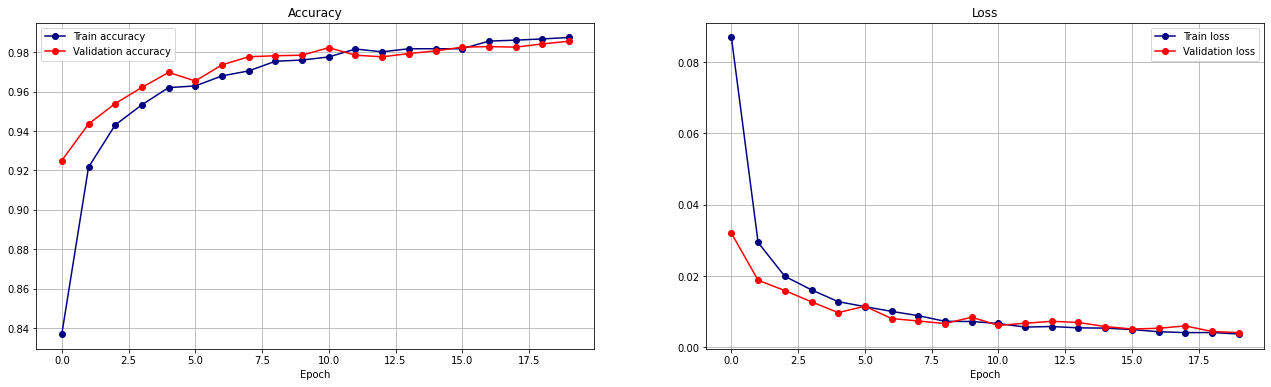

In [ ]:
plot_acc_loss(train_accuracy, validation_accuracy, train_loss, validation_loss)

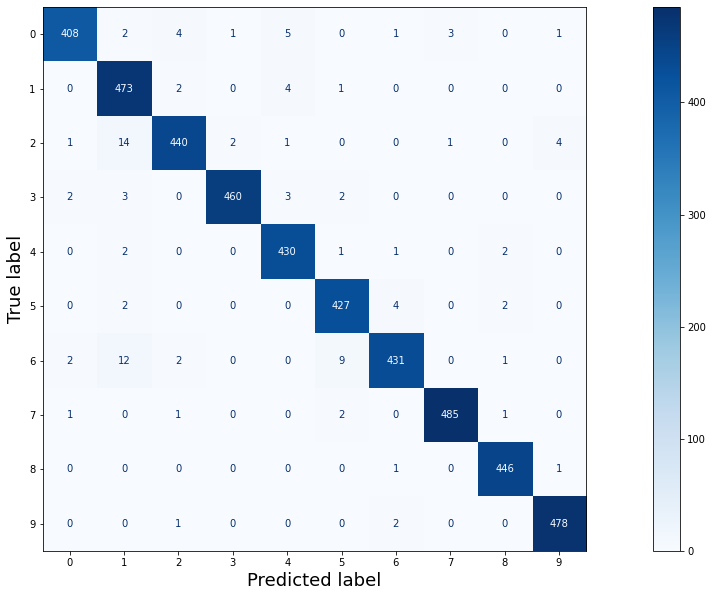

In [ ]:
plot_confusion_matrix()

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=list(classes.values())))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.99      0.96      0.97       425
                        Early_blight       0.93      0.99      0.96       480
                         Late_blight       0.98      0.95      0.96       463
                           Leaf_Mold       0.99      0.98      0.99       470
                  Septoria_leaf_spot       0.97      0.99      0.98       436
Spider_mites Two-spotted_spider_mite       0.97      0.98      0.97       435
                         Target_Spot       0.98      0.94      0.96       457
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       490
                 Tomato_mosaic_virus       0.99      1.00      0.99       448
                             healthy       0.99      0.99      0.99       481

                            accuracy                           0.98      4585
                           macro avg       0.98      0.98     

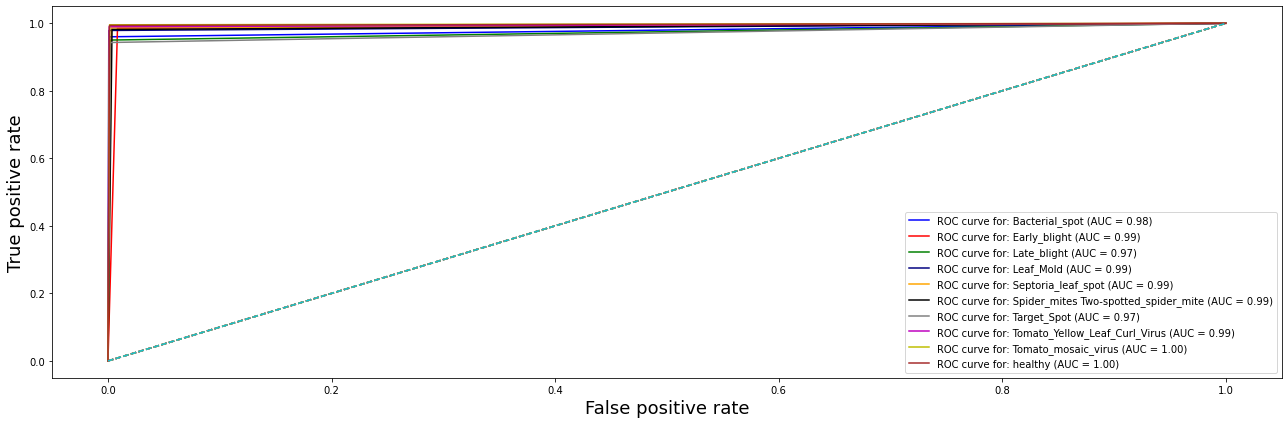

In [ ]:
plot_roc()

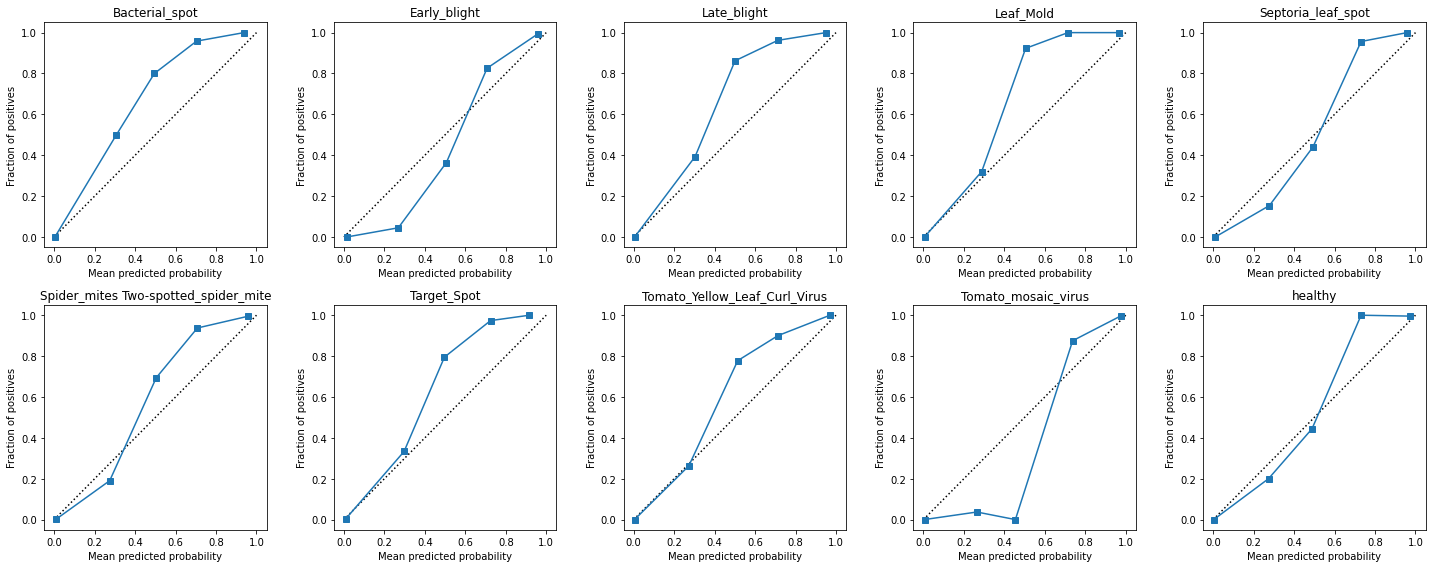

In [ ]:
plot_calibration()

# Final model optimization

Final model construction utilizing optimal parameters from Optuna study, while also increasing the training epochs from 20 to 30.

In [ ]:
# setting numbers of epochs to 30
num_epochs_new = 30

In [ ]:
# best model parameters
best_parameters = dict(study.best_params.items())
best_parameters

{'loss_function': 'MultiMarginLoss',
 'lr_layer4_1': 3.0349301296414345e-05,
 'lr_layer4_2': 4.0028055479862796e-07,
 'lr_classifier': 0.0031333553167871312,
 'scheduler_gamma': 0.6}

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(in_features=in_feat, out_features=n_classes)
    
for param in model.layer4[1:].parameters():
    param.requires_grad = True
    
model = model.to(device)

loss_fn = getattr(nn, best_parameters['loss_function'])()

optimizer = torch.optim.Adam([
        {'params': model.layer4[1].parameters(), 'lr': best_parameters['lr_layer4_1']},
        {'params': model.layer4[2].parameters(), 'lr': best_parameters['lr_layer4_2']},
        {'params': model.fc.parameters()}
        ], lr=best_parameters['lr_classifier'])
    
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=8, gamma=best_parameters['scheduler_gamma'])
    
acc_h_t = [0] * num_epochs_new
loss_h_t = [0] * num_epochs_new
acc_h_v = [0] * num_epochs_new
loss_h_v = [0] * num_epochs_new
    
for epoch in range(num_epochs_new):
        
    model.train()
    for x_t, y_t in train_dl:
        x_t = x_t.to(device)
        y_t = y_t.to(device)

        pred_t = model(x_t)
        loss_t = loss_fn(pred_t, y_t)
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
            
        corr_t = (torch.argmax(pred_t, dim=1) == y_t).float()
        acc_h_t[epoch] += corr_t.sum().cpu()
        loss_h_t[epoch] += loss_t.item()
    acc_h_t[epoch] /= len(train_ds)
    loss_h_t[epoch] /= len(train_dl)
        
    model.eval()
    with torch.no_grad():
        for x_v, y_v in valid_dl:
            x_v = x_v.to(device)
            y_v = y_v.to(device)
                
            pred_v = model(x_v)
            loss_v = loss_fn(pred_v, y_v)
                
            corr_v = (torch.argmax(pred_v, dim=1) == y_v).float()
            acc_h_v[epoch] += corr_v.sum().cpu()
            loss_h_v[epoch] += loss_v.item()
    acc_h_v[epoch] /= len(valid_ds)
    loss_h_v[epoch] /= len(valid_dl)
        
    scheduler.step()

# Final model testing

In [ ]:
# testing results (final model)
y_true, y_pred, y_prob = evaluete_model(model)

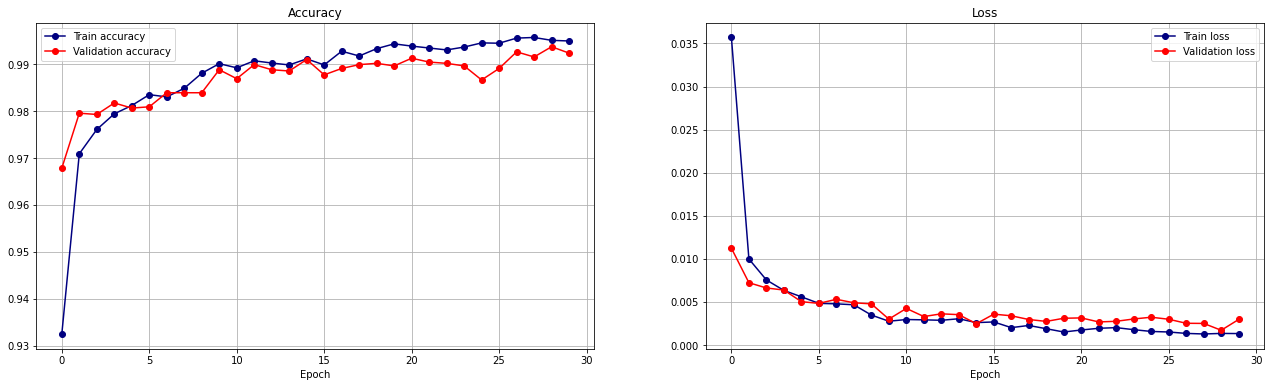

In [ ]:
plot_acc_loss(acc_h_t, acc_h_v, loss_h_t, loss_h_v)

Increasing the number of training epochs from 20 to 30 resulted in some improvement, but in the last epochs overfitting began to occur.
Examining the confusion matrix and classification report, it is evident that precision and recall were positively impacted by this implementation.

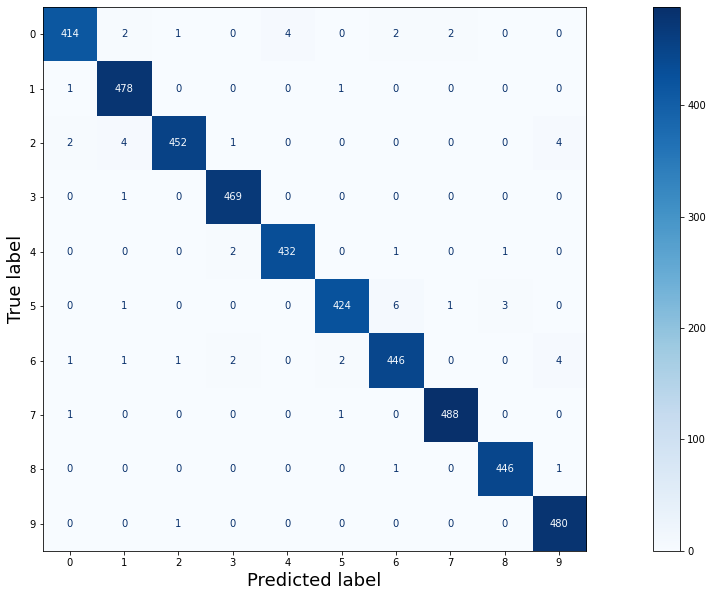

In [ ]:
plot_confusion_matrix()

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=list(classes.values())))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.99      0.97      0.98       425
                        Early_blight       0.98      1.00      0.99       480
                         Late_blight       0.99      0.98      0.98       463
                           Leaf_Mold       0.99      1.00      0.99       470
                  Septoria_leaf_spot       0.99      0.99      0.99       436
Spider_mites Two-spotted_spider_mite       0.99      0.97      0.98       435
                         Target_Spot       0.98      0.98      0.98       457
       Tomato_Yellow_Leaf_Curl_Virus       0.99      1.00      0.99       490
                 Tomato_mosaic_virus       0.99      1.00      0.99       448
                             healthy       0.98      1.00      0.99       481

                            accuracy                           0.99      4585
                           macro avg       0.99      0.99     

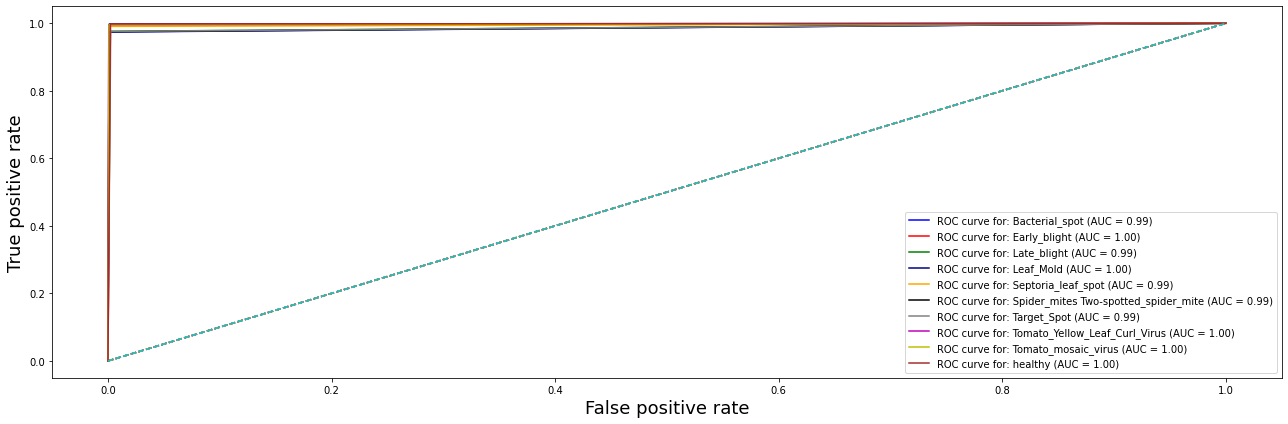

In [ ]:
plot_roc()

The final model has superior overall performance, but there is a discrepancy in the calibration of the different classes, which could impact decision-making post-classification. Specifically, the "healthy" class is more accurately calibrated in the intermediate model (with the best parameters and 20 epochs) than the final model. 

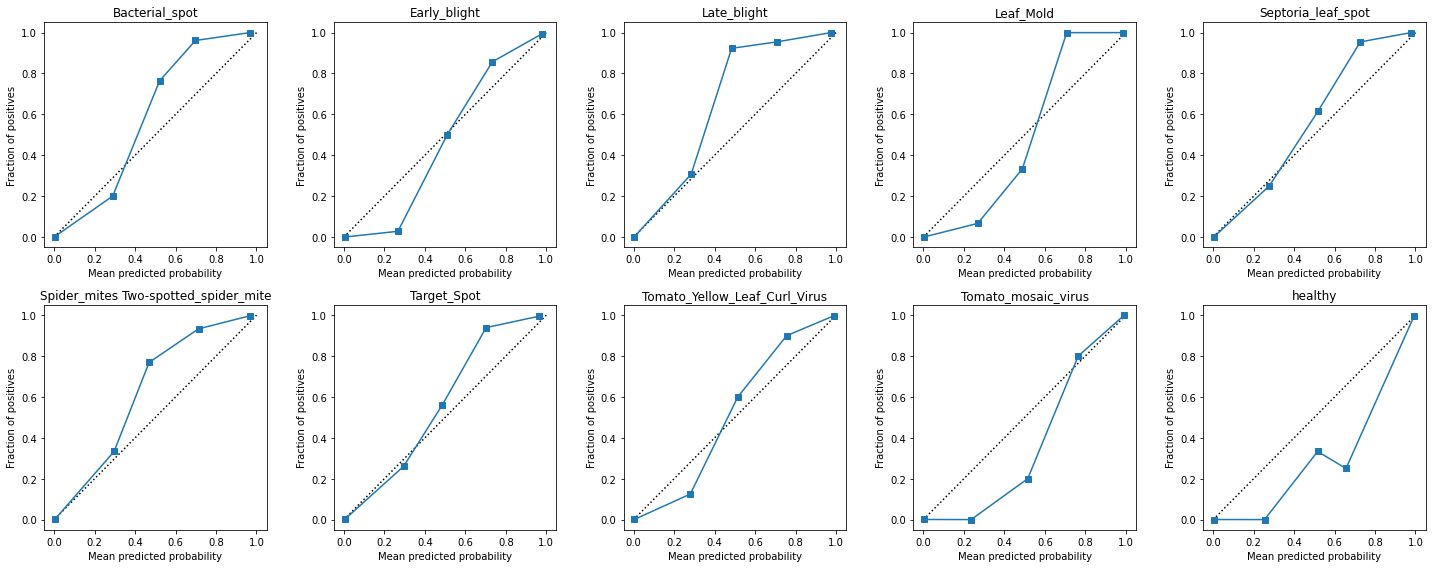

In [ ]:
plot_calibration()

In [ ]:
# saving final model
torch.save(model, 'final_model.pt')